# Kaggle installation

These are steps to be followed to import the kaggle dataset to the colab runspace

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Download the kaggle.json api token from your kaggle account and upload here


In [9]:
#download kaggle.json from your account from create new api token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavaramanbms","key":"34b741a6073b028c2af6dac99de176e4"}'}

In [10]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download plameneduardo/sarscov2-ctscan-dataset

 98% 225M/230M [00:01<00:00, 174MB/s]
100% 230M/230M [00:01<00:00, 133MB/s]


Exporting the files from the dataset.

In [13]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "sarscov2-ctscan-dataset.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


# Imports

In [14]:
import os
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random
import cv2

In [15]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#%pylab inline


#from sklearn.model_selection import train_test_split


%load_ext tensorboard
import datetime
from tensorflow.keras import layers

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Original model import

In [17]:
!cp /content/drive/MyDrive/Machine_Learning_Model_Files/COVID-19/vgg16pran.zip original_vgg16_model.zip

In [18]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "original_vgg16_model.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
saved_model/                                   2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/                    2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/assets/             2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/variables/          2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/variables/variables.data-00000-of-00001 2021-05-10 14:07:24    264409172
saved_model/vgg16pranmodel/variables/variables.index 2021-05-10 14:07:24         2963
saved_model/vgg16pranmodel/saved_model.pb      2021-05-10 14:07:24       354433
Extracting all the files now...
Done!


In [19]:
#set the location to your model's location
model_location = 'saved_model/vgg16pranmodel'

from tensorflow.keras.models import load_model
model = load_model(model_location)
model.trainable = False

In [20]:
#change to your model's input img_size
img_size = 224 

# custom-preprocessing function
def preprocessing_image(data):
    img_resize = cv2.resize(data, dsize=(img_size, img_size))
    image = np.array(img_resize, dtype='float32')
    image = tf.expand_dims(image,0)
    return image

#function that returns the predicted value
def prediction(data):
    value = model.predict(data)   
    return value[0][0]

This is the original model that can distinguish covid and non-covid


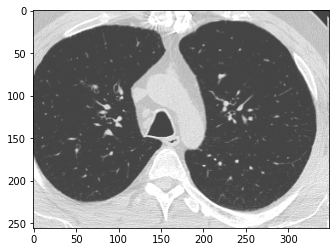

prediction for the above image is: 
1.0


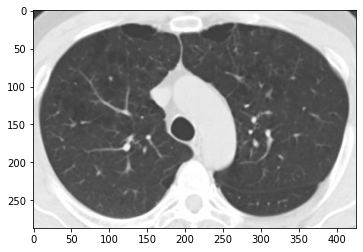

prediction for the above image is: 
4.3384417e-35


In [21]:
#checking if the model works

print("This is the original model that can distinguish covid and non-covid")
image_locations = ['/content/COVID/Covid (100).png', "/content/non-COVID/Non-Covid (1001).png"]

for image_location in image_locations:

  image = cv2.imread(image_location)
  plt.imshow(image)
  image = preprocessing_image(image)
  plt.show()
  pred = prediction(image)
  print("prediction for the above image is: ")
  print(pred)

# Attacker's model creation


## data generation

Here the images are once run and then the labels that is predicted from  the original model is appended to the list

In [ ]:

img = [] #create a list of (image, prediction_label)

for data in os.listdir('non-COVID'):
        img_d = cv2.imread('non-COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 0
        if pred>0.5:
          y_val = 1   #change the label

        # print(pred, y_val)
        img.append([img_d, y_val])    #append the image along with label in the list





In [ ]:

for data in os.listdir('/content/COVID'):
        img_d = cv2.imread('/content/COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 1
        if pred<0.5:
          y_val = 0   #change the label

        img.append([img_d, y_val])    #append the image along with label in the list
        # print(pred, y_val)
        # break



In [ ]:
len(img)

2481

New Histogram:


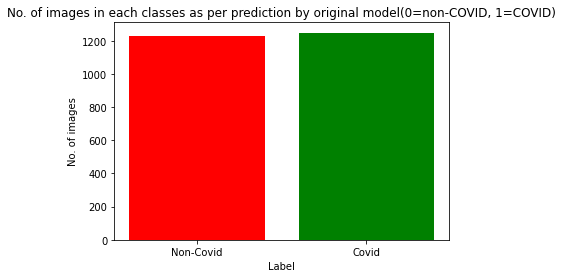

In [ ]:
img = np.array(img, dtype=object)
num_zeros = (img[:,1] == 0).sum()
num_ones = (img[:,1] == 1).sum()
print("New Histogram:")
plt.title('No. of images in each classes as per prediction by original model(0=non-COVID, 1=COVID)')
plt.ylabel('No. of images')
plt.xlabel('Label')
plt.bar(["Non-Covid", "Covid"], [num_zeros, num_ones] , color=["red", "green"])
plt.show()


In [ ]:

from sklearn.model_selection import train_test_split
X_img = []
Y_lab = []
for data in img:
    X_img.append(data[0][0])
    Y_lab.append(data[1])

X_arr_img = np.array(X_img)

X_train, X_test, Y_train, Y_test = train_test_split(X_arr_img, Y_lab, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

(array([259.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 238.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

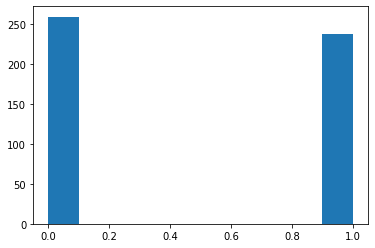

In [ ]:
# plt.hist(X_test.astype('int'))
plt.hist(Y_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1984, 224, 224, 3)
(497, 224, 224, 3)
(1984,)
(497,)


## ATTACKER'S MODEL DEFINITION

This model is trained on the created dataset

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def vgg16_new_model(base_model):
  x = layers.Flatten()(base_model.output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(base_model.input, x)
  return model

base_model = VGG16(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

new_model = vgg16_new_model(base_model)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [ ]:


history_new = new_model.fit(X_train,Y_train,
                    epochs=5,
                    validation_data=(X_test,Y_test),
                    verbose=1)

Epoch 1/5
62/62 [==============================] - 23s 362ms/step - loss: 25.4412 - accuracy: 0.7722 - val_loss: 0.3030 - val_accuracy: 0.9517
Epoch 2/5
62/62 [==============================] - 22s 354ms/step - loss: 0.1372 - accuracy: 0.9642 - val_loss: 0.1099 - val_accuracy: 0.9678
Epoch 3/5
62/62 [==============================] - 22s 354ms/step - loss: 0.0229 - accuracy: 0.9924 - val_loss: 0.1247 - val_accuracy: 0.9738
Epoch 4/5
62/62 [==============================] - 22s 355ms/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.1136 - val_accuracy: 0.9779
Epoch 5/5
62/62 [==============================] - 22s 355ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.1109 - val_accuracy: 0.9718


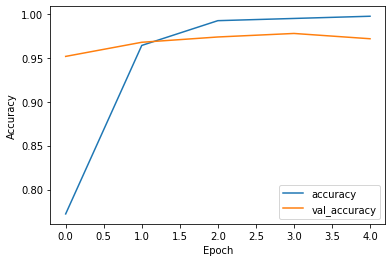

In [ ]:
plt.plot(history_new.history['accuracy'], label='accuracy')
plt.plot(history_new.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

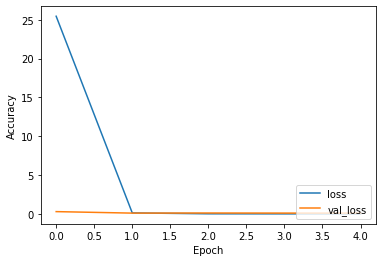

In [ ]:
plt.plot(history_new.history['loss'], label='loss')
plt.plot(history_new.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
y_pred = new_model.predict(X_test)
y = []
for i,d in enumerate(y_pred):
  if d[0] < 0.5:
    y.append(0)
  else:
    y.append(1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
conf_mat = confusion_matrix(Y_test, y)
print(conf_mat)

[[248  11]
 [  3 235]]


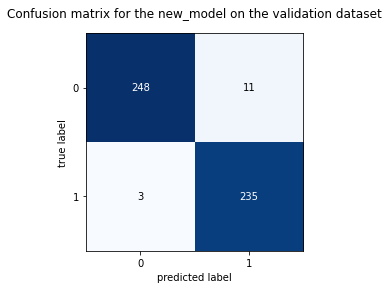

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array(conf_mat)

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.title('Confusion matrix for the new_model on the validation dataset')
plt.show()

In [ ]:

new_model.save('covid_attack_model/vgg16_covid_attacker')

INFO:tensorflow:Assets written to: covid_attack_model/vgg16_covid_attacker/assets


In [ ]:
!zip -r ./vgg16_covid_attacker.zip ./covid_attack_model/

  adding: covid_attack_model/ (stored 0%)
  adding: covid_attack_model/vgg16_covid_attacker/ (stored 0%)
  adding: covid_attack_model/vgg16_covid_attacker/assets/ (stored 0%)
  adding: covid_attack_model/vgg16_covid_attacker/saved_model.pb (deflated 91%)
  adding: covid_attack_model/vgg16_covid_attacker/variables/ (stored 0%)
  adding: covid_attack_model/vgg16_covid_attacker/variables/variables.index (deflated 67%)
  adding: covid_attack_model/vgg16_covid_attacker/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: covid_attack_model/vgg16_covid_attacker/keras_metadata.pb (deflated 95%)


In [ ]:
!cp vgg16_covid_attacker.zip '/content/drive/MyDrive/Machine_Learning_Model_Files/retinopathy/Final model/vgg16_covid_attacker_model.zip'

In [ ]:
new_model.trainable = False

## Using of already trained attacker model


In [ ]:
!cp '/content/drive/MyDrive/Machine_Learning_Model_Files/retinopathy/Final model/vgg16_covid_attacker_model.zip' vgg16_covid_attacker.zip

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "vgg16_covid_attacker.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
covid_attack_model/                            2022-03-27 10:45:52            0
covid_attack_model/vgg16_covid_attacker/       2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/assets/ 2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/saved_model.pb 2022-03-27 10:45:54       319190
covid_attack_model/vgg16_covid_attacker/variables/ 2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/variables/variables.index 2022-03-27 10:45:54         3192
covid_attack_model/vgg16_covid_attacker/variables/variables.data-00000-of-00001 2022-03-27 10:45:54    367183167
covid_attack_model/vgg16_covid_attacker/keras_metadata.pb 2022-03-27 10:45:54        53830
Extracting all the files now...
Done!


In [ ]:
model_location = 'covid_attack_model/vgg16_covid_attacker'

from tensorflow.keras.models import load_model
new_model = load_model(model_location)
new_model.trainable = False

# PGD ATTACK

This function computes the L-2 Norm of the given matrix


---



*   First it converts the 3d matrix into a 1d array
*   Then it performs L-2 norm where 
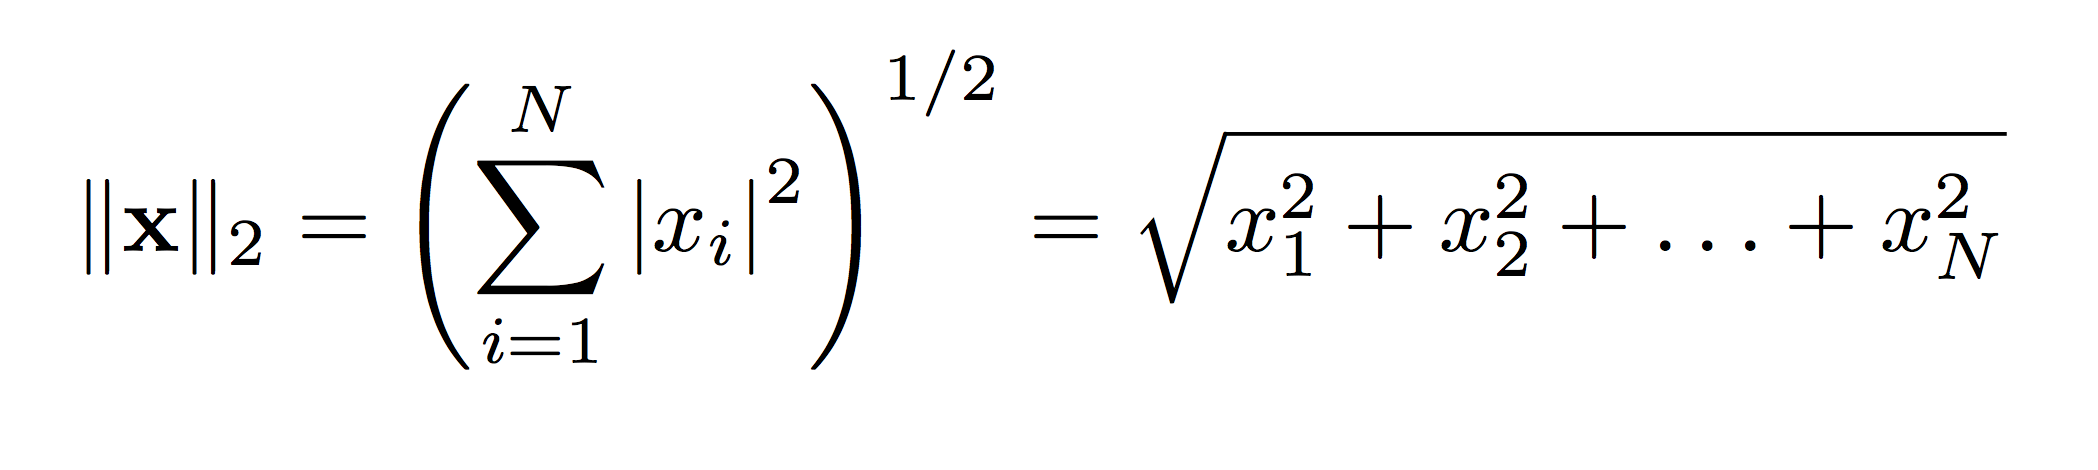
*   Then the normalized output is returned




In [ ]:
def l2_norm(z):
    """Compute norms over all but the first dimension"""

    mat = z.numpy()
    mat = mat.reshape((mat.shape[0], -1))
    out = np.linalg.norm(mat, ord=2)
    return out

    # The pytorch version of the code
    # return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None,None]

 **PGD Function**

The PGD used here is an iterative version of ‘Normalized Steepest Gradient Descent’. It perturbs a normal example x for a number of steps with the step size α being set between ϵ /T to ϵ. Here again we have made the model to iterate till it’s loss reaches a certain value

**Repeat:**
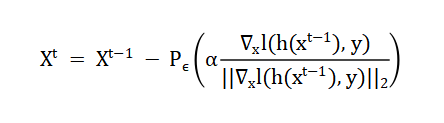





Some of the references used while creating this PGD are listed below:
* [Adversarial Examples, solving the inner maximization](https://adversarial-ml-tutorial.org/adversarial_examples/)
 - This helped us understand PGD much better and implemented in a better way
* [Understanding Adversarial Attacks on Deep Learning Based
Medical Image Analysis Systems](https://arxiv.org/pdf/1907.10456.pdf)


**The inner_pgd function returns the delta after one step**

The normalized steepest descent method has been used to find the noise to be 
added to the the image.

In contrast to Fast Gradient Sign Method, where
```
delta = alpha * tf.sign(grad)
```

We are us
```
delta = alpha  * (grad/l2_norm(grad))
```

In [ ]:
def inner_pgd(x, y_adv, alpha):
    loss_func = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as gt:
        gt.watch(x)
        
        label = new_model(x)
        loss = loss_func(y_adv, label)
        outputloss = loss.numpy()
        #print (loss)
        
    grad = gt.gradient(loss, x)


    norm_grad = l2_norm(grad)
    #here it is an implementation of normalized steepest descent
    if norm_grad:
      delta = alpha  * (grad/norm_grad)
    else:
      delta = alpha * tf.sign(grad)

    return delta, outputloss
    

**Projection function:**

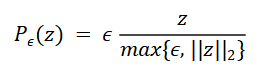

This particular projection function was mentioned in this article:

[Source](https://adversarial-ml-tutorial.org/adversarial_examples/)

In [ ]:
def projection(x, eps):
  norm_x = l2_norm(x)
  out = eps * (x / np.maximum(eps, norm_x))*255
  
  #here we found that the output value is very less because the value 
  #becomes in the range of 0 to 1 while the image is in the range of 0-255
  #so the output is multiplied with 255

  return out


In contrast with many places where the number of iterations for the PGD is already given,

here the iteration goes on until the loss for the given image and desired target becomes lesser that a certain threshold (in this case 0.5), the attack stops

Of course, this is not always the desirable way to do, as there is no fixed timeline for the attack to finish.

On our experiences usualy an image takes about 6-7 iterations

In [ ]:
def PGD(x, y_adv, eps):

  # attack changes from BIM to Madry's PGD
  delta = np.random.uniform(-eps,eps,x.shape)
  x = x+delta

  alpha = eps/10

  itr = 0

  while 1:
    noise, loss = inner_pgd(x, y_adv,alpha)
    #noise_new = tf.clip_by_value(x-noise-img, -eps, eps)
    noise_new = projection(noise , eps)
    x = x - noise_new
    #x = projection(x, eps)
    #print(x)

    #preds = new_model.predict(x)
    #print(preds)

    itr+=1
    if loss<1e-5 or itr>=10:
      break

  return x, itr


## creation of perturbed data

Here we will see an example of how the image is affected by the adversarial attack

**Create_Perturb**

This function takes in the image details and target value (to which the image has to change to) and saves the perturbed image in the given destination.

In [ ]:
def create_perturb_pgd(old_img, image_name, tofolder, y_val):
  #old_img = cv2.imread(fromfolder+'/'+image_name)
  old_img = preprocessing_image(old_img)

  #actual prediction by the model
  preds = new_model.predict(old_img)
  print("The prediction of the image before attack: ", preds)

  #y_val = 0
    
  #if preds[0][0]<0.5:
    #y_val = 1
    
  #target value
  y_adv_label = y_val
  y_adv = tf.reshape(y_adv_label, shape=[1, preds.shape[-1]])


  #adverserial image


  x_adv, itrs = PGD(old_img, y_adv, 1.4)

  #here noise is calculated to display it, it is not necessary to show the noise
  #noise = x_adv - img
  #plt.imshow(noise[0])
  #plt.show()


  #prediction by the model after adversarial attack
  newpreds = new_model.predict(x_adv)
  print("The prediction of the image after %d iterations of PGD attack: %f" % ( itrs, newpreds[0][0]))

  #saving image to the destination
  save_img(tofolder+'/'+image_name, x_adv[0])

Example image:-

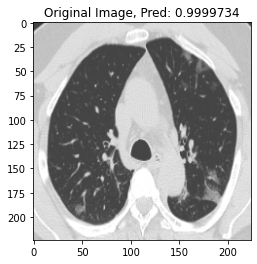

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


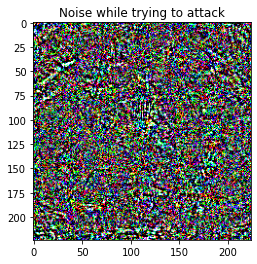

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The prediction of the image after 6 iterations of PGD attack 0.000000


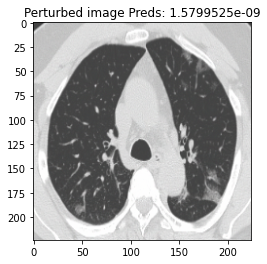

In [ ]:
which_number = 94

# new_img = img[which_number][0]
# actual_label = img[which_number][1]

# print(new_img.shape)

new_img = X_train[which_number]
actual_label = Y_train[which_number]

new_img = preprocessing_image(new_img)

y_label = 0
if actual_label==0:
  y_label = 1

old_pred = new_model.predict(new_img)
plt.imshow(new_img[0]/255)
plt.title('Original Image, Pred: '+str(old_pred[0][0]))
plt.show()

y_adv = tf.reshape(y_label, shape=[1, old_pred.shape[-1]])

x_adv, itrs = PGD(new_img, y_adv, 1.4)

noise = x_adv - new_img
plt.imshow(noise[0])
plt.title('Noise while trying to attack')
plt.show()

new_preds = new_model.predict(x_adv)
print("The prediction of the image after %d iterations of PGD attack %f" % ( itrs, new_preds[0][0]))

plt.imshow(x_adv[0]/255)
plt.title('Perturbed image Preds: '+str(new_preds[0][0]))
plt.show()


In [ ]:
!mkdir PGD_BBA_COVID_PERTURBED
!mkdir PGD_BBA_COVID_PERTURBED/COVID
!mkdir PGD_BBA_COVID_PERTURBED/non-COVID

In [ ]:
covid = 0
non_covid = 0

for i,d in enumerate(X_train):
  print(i)
  if Y_train[i] == 1:
    create_perturb_pgd(d, 'COVID('+str(covid)+').png', 'PGD_BBA_COVID_PERTURBED/COVID/', 0)
    print('COVID('+str(covid)+').png')
    covid+=1
  else:
    create_perturb_pgd(d, 'non-COVID('+str(non_covid)+').png', 'PGD_BBA_COVID_PERTURBED/non-COVID/', 1)
    print('non-COVID('+str(non_covid)+').png')
    non_covid+=1


Streaming output truncated to the last 5000 lines.
734
The prediction of the image before attack:  [[6.96987e-07]]
The prediction of the image after 7 iterations of PGD attack: 1.000000
non-COVID(371).png
735
The prediction of the image before attack:  [[7.5796817e-07]]
The prediction of the image after 5 iterations of PGD attack: 1.000000
non-COVID(372).png
736
The prediction of the image before attack:  [[1.]]
The prediction of the image after 10 iterations of PGD attack: 0.000001
COVID(363).png
737
The prediction of the image before attack:  [[1.]]
The prediction of the image after 10 iterations of PGD attack: 0.000009
COVID(364).png
738
The prediction of the image before attack:  [[1.]]
The prediction of the image after 9 iterations of PGD attack: 0.000000
COVID(365).png
739
The prediction of the image before attack:  [[3.6767794e-06]]
The prediction of the image after 7 iterations of PGD attack: 1.000000
non-COVID(373).png
740
The prediction of the image before attack:  [[4.497877

In [ ]:
!zip -r ./PGD_BBA_COVID_PERTURBED.zip ./PGD_BBA_COVID_PERTURBED/

  adding: PGD_BBA_COVID_PERTURBED/ (stored 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/ (stored 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(521).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(425).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(48).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(83).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(295).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(964).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(707).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(541).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(474).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(221).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COVID(652).png (deflated 0%)
  adding: PGD_BBA_COVID_PERTURBED/non-COVID/non-COV

In [ ]:
!cp ./PGD_BBA_COVID_PERTURBED.zip "/content/drive/MyDrive/Machine_Learning_Model_Files/PGD_BBA_COVID_PERTURBED.zip"

## evaluation of pgd - bba

In [ ]:
!cp "/content/drive/MyDrive/Machine_Learning_Model_Files/PGD_BBA_COVID_PERTURBED.zip" ./PGD_BBA_COVID_PERTURBED.zip 

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "PGD_BBA_COVID_PERTURBED.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [ ]:
import cv2

covid_img = []
for data in os.listdir('PGD_BBA_COVID_PERTURBED/COVID'):
        img_d = cv2.imread('PGD_BBA_COVID_PERTURBED/COVID/{}'.format(data))
        covid_img.append(img_d)

        
non_covid_img = []        
for data in os.listdir('PGD_BBA_COVID_PERTURBED/non-COVID'):
        img_d = cv2.imread('PGD_BBA_COVID_PERTURBED/non-COVID/{}'.format(data))        
        non_covid_img.append(img_d)


In [ ]:
covid_img = np.array(covid_img)
covid_img_pred = model.predict(covid_img)

In [ ]:
covid_img_pred_int = []
for i in covid_img_pred:
  if i < 0.5:
    covid_img_pred_int.append(0)
  else:
    covid_img_pred_int.append(1)

total no. of covid images =  1011
Predicted as Non - covid =  775
Predicted as DR =  236
New Histogram:


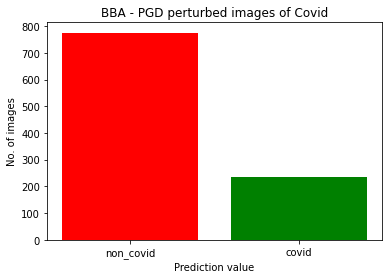

In [ ]:
# no_of_zero = dr_new_pred.
covid_img_pred_int = np.array(covid_img_pred_int)
no_zero = (covid_img_pred_int ==0).sum()
no_one = (covid_img_pred_int==1).sum()
print("total no. of covid images = ", covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as DR = ", no_one)

print("New Histogram:")
plt.title('BBA - PGD perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()

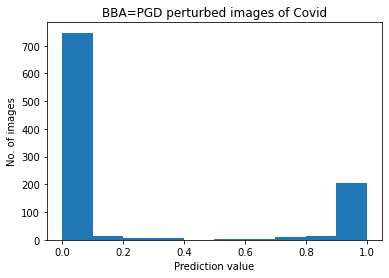

In [ ]:
plt.title('BBA=PGD perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(covid_img_pred.astype('float'))
plt.show()

In [ ]:
non_covid_img = np.array(non_covid_img)
non_covid_img_pred = model.predict(non_covid_img)

In [ ]:
non_covid_img_pred_int = []
for i in non_covid_img_pred:
  if i < 0.5:
    non_covid_img_pred_int.append(0)
  else:
    non_covid_img_pred_int.append(1)

total no. of non_covid images =  973
Predicted as Non - covid =  17
Predicted as DR =  956


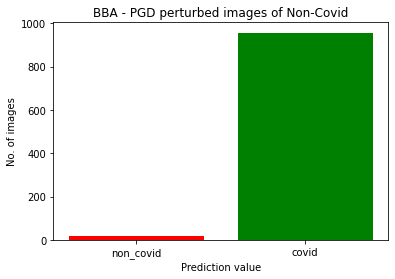

In [ ]:
# no_of_zero = dr_new_pred.
non_covid_img_pred_int = np.array(non_covid_img_pred_int)
no_zero = (non_covid_img_pred_int ==0).sum()
no_one = (non_covid_img_pred_int==1).sum()
print("total no. of non_covid images = ", non_covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as DR = ", no_one)


plt.title('BBA - PGD perturbed images of Non-Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()

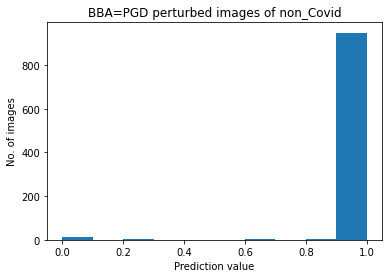

In [ ]:
plt.title('BBA=PGD perturbed images of non_Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(non_covid_img_pred.astype('float'))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
for i in covid_img_pred_int:
  y_pred.append(i)
  y_true.append(1)

for i in non_covid_img_pred_int:
  y_pred.append(i)
  y_true.append(0)

cnf = confusion_matrix(y_true, y_pred)
cnf

array([[ 17, 956],
       [775, 236]])

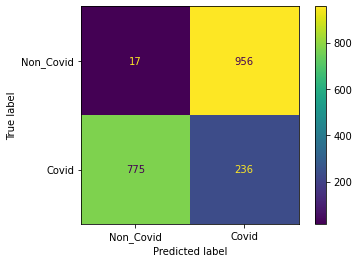

In [ ]:
disp = ConfusionMatrixDisplay(cnf,display_labels=["Non_Covid", "Covid"])
disp.plot()

# BIM ATTACK

In [22]:
!cp '/content/drive/MyDrive/Machine_Learning_Model_Files/retinopathy/Final model/vgg16_covid_attacker_model.zip' vgg16_covid_attacker.zip

In [23]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "vgg16_covid_attacker.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
covid_attack_model/                            2022-03-27 10:45:52            0
covid_attack_model/vgg16_covid_attacker/       2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/assets/ 2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/saved_model.pb 2022-03-27 10:45:54       319190
covid_attack_model/vgg16_covid_attacker/variables/ 2022-03-27 10:45:54            0
covid_attack_model/vgg16_covid_attacker/variables/variables.index 2022-03-27 10:45:54         3192
covid_attack_model/vgg16_covid_attacker/variables/variables.data-00000-of-00001 2022-03-27 10:45:54    367183167
covid_attack_model/vgg16_covid_attacker/keras_metadata.pb 2022-03-27 10:45:54        53830
Extracting all the files now...
Done!


In [24]:
model_location = 'covid_attack_model/vgg16_covid_attacker'

from tensorflow.keras.models import load_model
new_model = load_model(model_location)
new_model.trainable = False

In [25]:

img = [] #create a list of (image, prediction_label)
for data in os.listdir('non-COVID'):
        img_d = cv2.imread('non-COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 0
        if pred>0.5:
          y_val = 1   #change the label

        # print(pred, y_val)
        img.append([img_d, y_val])    #append the image along with label in the list





In [26]:

for data in os.listdir('/content/COVID'):
        img_d = cv2.imread('/content/COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 1
        if pred<0.5:
          y_val = 0   #change the label

        img.append([img_d, y_val])    #append the image along with label in the list
        # print(pred, y_val)
        # break



In [27]:
len(img)

2481

New Histogram:


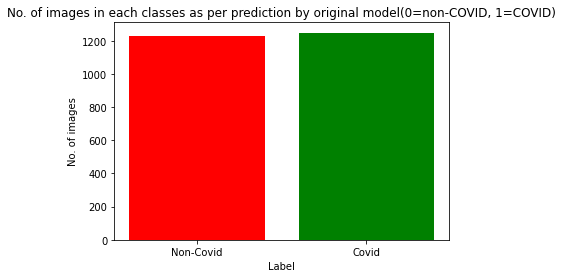

In [28]:
img = np.array(img, dtype=object)
num_zeros = (img[:,1] == 0).sum()
num_ones = (img[:,1] == 1).sum()
print("New Histogram:")
plt.title('No. of images in each classes as per prediction by original model(0=non-COVID, 1=COVID)')
plt.ylabel('No. of images')
plt.xlabel('Label')
plt.bar(["Non-Covid", "Covid"], [num_zeros, num_ones] , color=["red", "green"])
plt.show()


In [29]:

from sklearn.model_selection import train_test_split
X_img = []
Y_lab = []
for data in img:
    X_img.append(data[0][0])
    Y_lab.append(data[1])

X_arr_img = np.array(X_img)

X_train, X_test, Y_train, Y_test = train_test_split(X_arr_img, Y_lab, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

(array([252.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 245.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

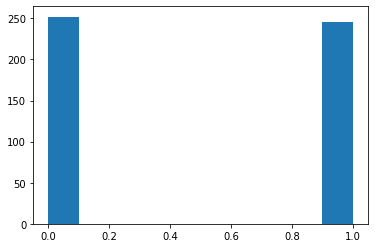

In [30]:
# plt.hist(X_test.astype('int'))
plt.hist(Y_test)

**FGSM**

For an input image, this method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. 

In [33]:

def fgsm(x, y_adv, epsilon):
    loss_func = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as gt:
        gt.watch(x)
        
        label = new_model(x)
        loss = loss_func(y_adv, label)
        outputloss = loss.numpy()
        #print (loss)
        
    grad = gt.gradient(loss, x)
    gamma = epsilon * tf.sign(grad)
    
    return gamma, outputloss
    

**BIM**

FGSM is performed certain number of times. 

In many cases, the number of iterations is already given. 

But here, a number of iterations are performed until we reach the target. Here, the attack stops once the loss for the given image goes below a particular value (2 in this case).

On an average the number of iterations performed here is 3-4.

The recursive function of BIM is:

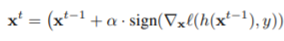

In [63]:
def BIM(x, y_adv, eps):
  alpha = eps/10
  itrs = 0
  while 1:
    noise, loss = fgsm(x, y_adv,alpha)
    #noise = tf.clip_by_value(x-noise-img, -eps, eps)
    x = x - noise

    #preds = new_model.predict(x)
    #print(preds)
    itrs+=1
    if loss<2 or itrs>10:
      break

  return x, itrs

This function takes in the image details and target value (to which the image has to change to) and saves the perturbed image in the given destination.

In [35]:
def create_perturb(image_name, fromfolder, tofolder, yval):
  old_img = cv2.imread(fromfolder+'/'+image_name)

  old_img = preprocessing_image(old_img)

  preds = new_model.predict(old_img)
  
  print(preds)

  intpred = round(preds[0][0])
  
  y_adv_label = yval
  
  y_adv = tf.reshape(y_adv_label, shape=[1, preds.shape[-1]])
 
  print(y_adv)
  x_adv = BIM(img, y_adv, 1.4)

  noise = x_adv - old_img
  
  newpreds = new_model.predict(x_adv)
  
  print(newpreds)
  save_img(tofolder+'/'+image_name, x_adv[0])


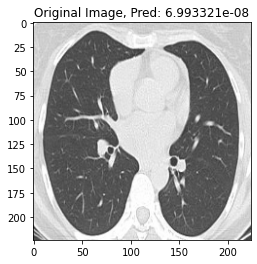

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


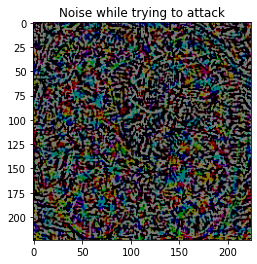

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The prediction of the image after 7 iterations of BIM attack 0.878905


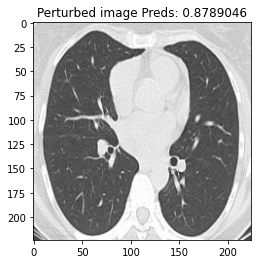

In [64]:
which_number = 4

#new_img = img[which_number][0]
#actual_label = img[which_number][1]

new_img = X_train[which_number]
actual_label = Y_train[which_number]

new_img = preprocessing_image(new_img)
y_label = 0
if actual_label==0:
  y_label = 1

old_pred = new_model.predict(new_img)
plt.imshow(new_img[0]/255)
plt.title('Original Image, Pred: '+str(old_pred[0][0]))
plt.show()

y_adv = tf.reshape(y_label, shape=[1, old_pred.shape[-1]])

x_adv, itrs = BIM(new_img, y_adv, 0.7)

noise = x_adv - new_img
plt.imshow(noise[0])
plt.title('Noise while trying to attack')
plt.show()

new_preds = new_model.predict(x_adv)
print("The prediction of the image after %d iterations of BIM attack %f" % ( itrs, new_preds[0][0]))

plt.imshow(x_adv[0]/255)
plt.title('Perturbed image Preds: '+str(new_preds[0][0]))
plt.show()


# perturbation creation


In [65]:
def create_perturb_bim(old_img, image_name, tofolder, y_val):
  #old_img = cv2.imread(fromfolder+'/'+image_name)
  old_img = preprocessing_image(old_img)

  #actual prediction by the model
  preds = new_model.predict(old_img)
  print("The prediction of the image before attack: ", preds)

  #y_val = 0
    
  #if preds[0][0]<0.5:
    #y_val = 1
    
  #target value
  y_adv_label = y_val
  y_adv = tf.reshape(y_adv_label, shape=[1, preds.shape[-1]])


  #adverserial image


  x_adv, itrs = BIM(old_img, y_adv, 1.4)

  #here noise is calculated to display it, it is not necessary to show the noise
  #noise = x_adv - img
  #plt.imshow(noise[0])
  #plt.show()


  #prediction by the model after adversarial attack
  newpreds = new_model.predict(x_adv)
  print("The prediction of the image after %d iterations of BIM attack: %f" % ( itrs, newpreds[0][0]))

  #saving image to the destination
  save_img(tofolder+'/'+image_name, x_adv[0])

In [66]:
!mkdir BIM_BBA_COVID_perturbed
!mkdir BIM_BBA_COVID_perturbed/non-COVID
!mkdir BIM_BBA_COVID_perturbed/COVID

mkdir: cannot create directory ‘BIM_BBA_COVID_perturbed’: File exists
mkdir: cannot create directory ‘BIM_BBA_COVID_perturbed/non-COVID’: File exists
mkdir: cannot create directory ‘BIM_BBA_COVID_perturbed/COVID’: File exists


In [67]:
covid = 0
non_covid = 0

for i,d in enumerate(X_train):
  print(i)
  if Y_train[i] == 1:
    create_perturb_bim(d, 'COVID('+str(covid)+').png', 'BIM_BBA_COVID_perturbed/COVID/', 0)
    print('COVID('+str(covid)+').png')
    covid+=1
  else:
    create_perturb_bim(d, 'non-COVID('+str(non_covid)+').png', 'BIM_BBA_COVID_perturbed/non-COVID/', 1)
    print('non-COVID('+str(non_covid)+').png')
    non_covid+=1

Streaming output truncated to the last 5000 lines.
734
The prediction of the image before attack:  [[0.23937534]]
The prediction of the image after 1 iterations of BIM attack: 0.000957
COVID(374).png
735
The prediction of the image before attack:  [[1.]]
The prediction of the image after 6 iterations of BIM attack: 0.031647
COVID(375).png
736
The prediction of the image before attack:  [[2.471377e-07]]
The prediction of the image after 4 iterations of BIM attack: 0.978549
non-COVID(360).png
737
The prediction of the image before attack:  [[1.]]
The prediction of the image after 7 iterations of BIM attack: 0.012247
COVID(376).png
738
The prediction of the image before attack:  [[1.6474737e-11]]
The prediction of the image after 6 iterations of BIM attack: 0.928988
non-COVID(361).png
739
The prediction of the image before attack:  [[0.00216094]]
The prediction of the image after 2 iterations of BIM attack: 0.934342
non-COVID(362).png
740
The prediction of the image before attack:  [[5.13

In [68]:
for i,d in enumerate(X_test):
  print(i)
  if Y_test[i] == 1:
    create_perturb_bim(d, 'COVID('+str(covid)+').png', 'BIM_BBA_COVID_perturbed/COVID/', 0)
    print('COVID('+str(covid)+').png')
    covid+=1
  else:
    create_perturb_bim(d, 'non-COVID('+str(non_covid)+').png', 'BIM_BBA_COVID_perturbed/non-COVID/', 1)
    print('non-COVID('+str(non_covid)+').png')
    non_covid+=1

0
The prediction of the image before attack:  [[0.9997992]]
The prediction of the image after 3 iterations of BIM attack: 0.000120
COVID(1004).png
1
The prediction of the image before attack:  [[2.6042874e-06]]
The prediction of the image after 3 iterations of BIM attack: 0.998226
non-COVID(980).png
2
The prediction of the image before attack:  [[1.]]
The prediction of the image after 5 iterations of BIM attack: 0.000209
COVID(1005).png
3
The prediction of the image before attack:  [[1.9635534e-06]]
The prediction of the image after 3 iterations of BIM attack: 0.996592
non-COVID(981).png
4
The prediction of the image before attack:  [[0.99996495]]
The prediction of the image after 3 iterations of BIM attack: 0.000385
COVID(1006).png
5
The prediction of the image before attack:  [[1.8634411e-08]]
The prediction of the image after 4 iterations of BIM attack: 0.957442
non-COVID(982).png
6
The prediction of the image before attack:  [[0.9999386]]
The prediction of the image after 3 iterati

In [69]:
!zip -r ./BIM_BBA_COVID_perturbed.zip ./BIM_BBA_COVID_perturbed/

updating: BIM_BBA_COVID_perturbed/ (stored 0%)
updating: BIM_BBA_COVID_perturbed/COVID/ (stored 0%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(414).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(651).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(706).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(1095).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(116).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(311).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(559).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(1186).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(487).png (deflated 0%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(1110).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(1183).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(928).png (deflated 1%)
updating: BIM_BBA_COVID_perturbed/COVID/COVID(656).png (deflated 0%)

In [70]:
!cp ./BIM_BBA_COVID_perturbed.zip "/content/drive/MyDrive/Machine_Learning_Model_Files/BIM_BBA_COVID_perturbed.zip"

## evaluation of BIM - BBA

In [71]:
!cp "/content/drive/MyDrive/Machine_Learning_Model_Files/BIM_BBA_COVID_perturbed.zip" ./BIM_BBA_COVID_perturbed.zip 

In [72]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "BIM_BBA_COVID_perturbed.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [73]:
import cv2

covid_img = []
for data in os.listdir('BIM_BBA_COVID_perturbed/COVID'):
        img_d = cv2.imread('BIM_BBA_COVID_perturbed/COVID/{}'.format(data))
        covid_img.append(img_d)

        
non_covid_img = []        
for data in os.listdir('BIM_BBA_COVID_perturbed/non-COVID'):
        img_d = cv2.imread('BIM_BBA_COVID_perturbed/non-COVID/{}'.format(data))        
        non_covid_img.append(img_d)


In [74]:
covid_img = np.array(covid_img)
covid_img_pred = model.predict(covid_img)

In [75]:
covid_img_pred_int = []
for i in covid_img_pred:
  if i < 0.5:
    covid_img_pred_int.append(0)
  else:
    covid_img_pred_int.append(1)

total no. of covid images =  1249
Predicted as Non - covid =  253
Predicted as DR =  996


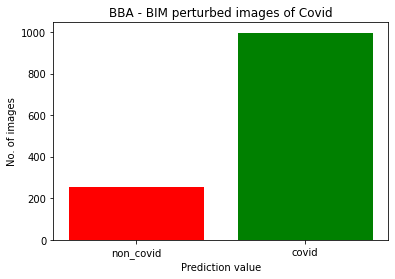

In [76]:
# no_of_zero = dr_new_pred.
covid_img_pred_int = np.array(covid_img_pred_int)
no_zero = (covid_img_pred_int ==0).sum()
no_one = (covid_img_pred_int==1).sum()
print("total no. of covid images = ", covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as DR = ", no_one)

plt.title('BBA - BIM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()

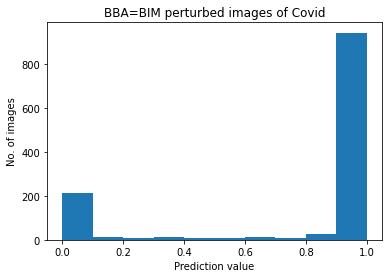

In [77]:
plt.title('BBA=BIM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(covid_img_pred.astype('float'))
plt.show()

In [78]:
non_covid_img = np.array(non_covid_img)
non_covid_img_pred = model.predict(non_covid_img)

In [79]:
non_covid_img_pred_int = []
for i in non_covid_img_pred:
  if i < 0.5:
    non_covid_img_pred_int.append(0)
  else:
    non_covid_img_pred_int.append(1)

total no. of non_covid images =  1232
Predicted as Non - covid =  498
Predicted as DR =  734


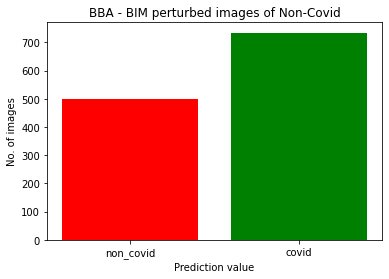

In [80]:
# no_of_zero = dr_new_pred.
non_covid_img_pred_int = np.array(non_covid_img_pred_int)
no_zero = (non_covid_img_pred_int ==0).sum()
no_one = (non_covid_img_pred_int==1).sum()
print("total no. of non_covid images = ", non_covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as DR = ", no_one)


plt.title('BBA - BIM perturbed images of Non-Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()

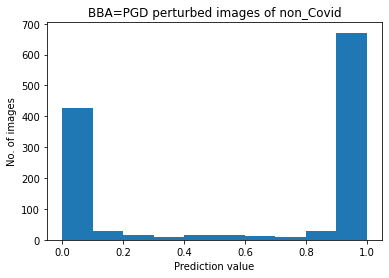

In [81]:
plt.title('BBA=PGD perturbed images of non_Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(non_covid_img_pred.astype('float'))
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
for i in covid_img_pred_int:
  y_pred.append(i)
  y_true.append(1)

for i in non_covid_img_pred_int:
  y_pred.append(i)
  y_true.append(0)

cnf = confusion_matrix(y_true, y_pred)
cnf

array([[498, 734],
       [253, 996]])

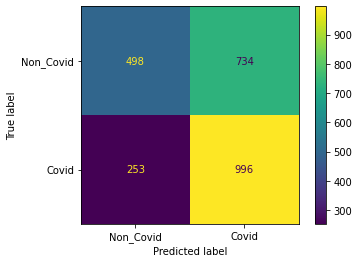

In [83]:
disp = ConfusionMatrixDisplay(cnf,display_labels=["Non_Covid", "Covid"])
disp.plot()